In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the dataset
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape input data for neural network
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [3]:
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])


In [4]:
def train_and_evaluate(optimizer, optimizer_name, epochs=10, batch_size=64):
    model = create_model()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training loop
        for x_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            
            # Apply gradients using the custom or built-in optimizer
            if isinstance(optimizer, (SGD, SGDMomentum, Adam)):
                optimizer.apply_gradients(gradients, model.trainable_variables)
            else:
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Evaluate training accuracy
        train_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_batch, y_batch in train_dataset:
            predictions = model(x_batch, training=False)
            train_accuracy.update_state(y_batch, predictions)
        train_accuracies.append(train_accuracy.result().numpy())

        # Evaluate test accuracy
        test_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_batch, y_batch in test_dataset:
            predictions = model(x_batch, training=False)
            test_accuracy.update_state(y_batch, predictions)
        test_accuracies.append(test_accuracy.result().numpy())

        print(f"Epoch {epoch + 1}/{epochs}, Optimizer: {optimizer_name}, Train Accuracy: {train_accuracy.result().numpy():.4f}, Test Accuracy: {test_accuracy.result().numpy():.4f}")
    
    return train_accuracies, test_accuracies


In [6]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def apply_gradients(self, gradients, variables):
        for grad, var in zip(gradients, variables):
            var.assign_sub(self.learning_rate * grad)


In [7]:
class SGDMomentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocities = {}

    def apply_gradients(self, gradients, variables):
        for i, (grad, var) in enumerate(zip(gradients, variables)):
            if i not in self.velocities:
                self.velocities[i] = tf.zeros_like(var)
            velocity = self.momentum * self.velocities[i] + grad
            self.velocities[i] = velocity
            var.assign_sub(self.learning_rate * velocity)

In [8]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def apply_gradients(self, gradients, variables):
        self.t += 1
        for i, (grad, var) in enumerate(zip(gradients, variables)):
            if i not in self.m:
                self.m[i] = tf.zeros_like(var)
                self.v[i] = tf.zeros_like(var)

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * tf.square(grad)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            var.assign_sub(self.learning_rate * m_hat / (tf.sqrt(v_hat) + self.epsilon))

In [9]:
# Custom optimizers
custom_sgd = SGD(learning_rate=0.01)
custom_sgd_momentum = SGDMomentum(learning_rate=0.01, momentum=0.9)
custom_adam = Adam(learning_rate=0.001)

# Built-in optimizers
tf_sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
tf_sgd_momentum = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
tf_adam = tf.keras.optimizers.Adam(learning_rate=0.001)


In [10]:
# Dictionary to store results
results = {}

# Train with Custom SGD
results["Custom SGD"] = train_and_evaluate(custom_sgd, "Custom SGD")

# Train with Custom SGD with Momentum
results["Custom SGD with Momentum"] = train_and_evaluate(custom_sgd_momentum, "Custom SGD with Momentum")

# Train with Custom Adam
results["Custom Adam"] = train_and_evaluate(custom_adam, "Custom Adam")

# Train with TensorFlow SGD
results["TensorFlow SGD"] = train_and_evaluate(tf_sgd, "TensorFlow SGD")

# Train with TensorFlow SGD with Momentum
results["TensorFlow SGD with Momentum"] = train_and_evaluate(tf_sgd_momentum, "TensorFlow SGD with Momentum")

# Train with TensorFlow Adam
results["TensorFlow Adam"] = train_and_evaluate(tf_adam, "TensorFlow Adam")


Epoch 1/10, Optimizer: Custom SGD, Train Accuracy: 0.8781, Test Accuracy: 0.8854
Epoch 2/10, Optimizer: Custom SGD, Train Accuracy: 0.9043, Test Accuracy: 0.9087
Epoch 3/10, Optimizer: Custom SGD, Train Accuracy: 0.9154, Test Accuracy: 0.9192
Epoch 4/10, Optimizer: Custom SGD, Train Accuracy: 0.9215, Test Accuracy: 0.9249
Epoch 5/10, Optimizer: Custom SGD, Train Accuracy: 0.9290, Test Accuracy: 0.9306
Epoch 6/10, Optimizer: Custom SGD, Train Accuracy: 0.9351, Test Accuracy: 0.9340
Epoch 7/10, Optimizer: Custom SGD, Train Accuracy: 0.9383, Test Accuracy: 0.9358
Epoch 8/10, Optimizer: Custom SGD, Train Accuracy: 0.9433, Test Accuracy: 0.9412
Epoch 9/10, Optimizer: Custom SGD, Train Accuracy: 0.9463, Test Accuracy: 0.9432
Epoch 10/10, Optimizer: Custom SGD, Train Accuracy: 0.9498, Test Accuracy: 0.9468
Epoch 1/10, Optimizer: Custom SGD with Momentum, Train Accuracy: 0.9503, Test Accuracy: 0.9476
Epoch 2/10, Optimizer: Custom SGD with Momentum, Train Accuracy: 0.9669, Test Accuracy: 0.9626

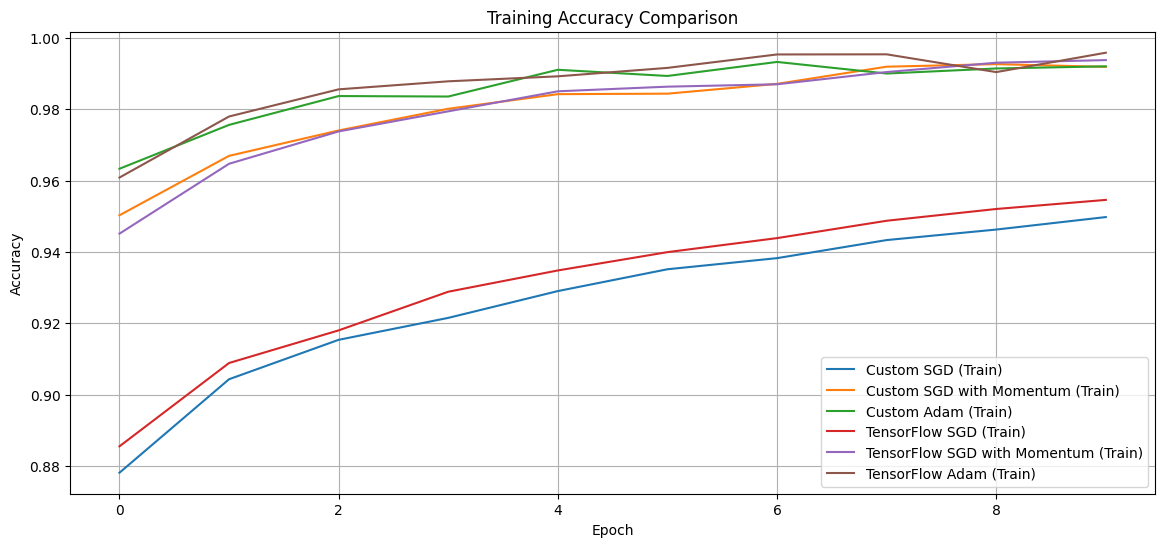

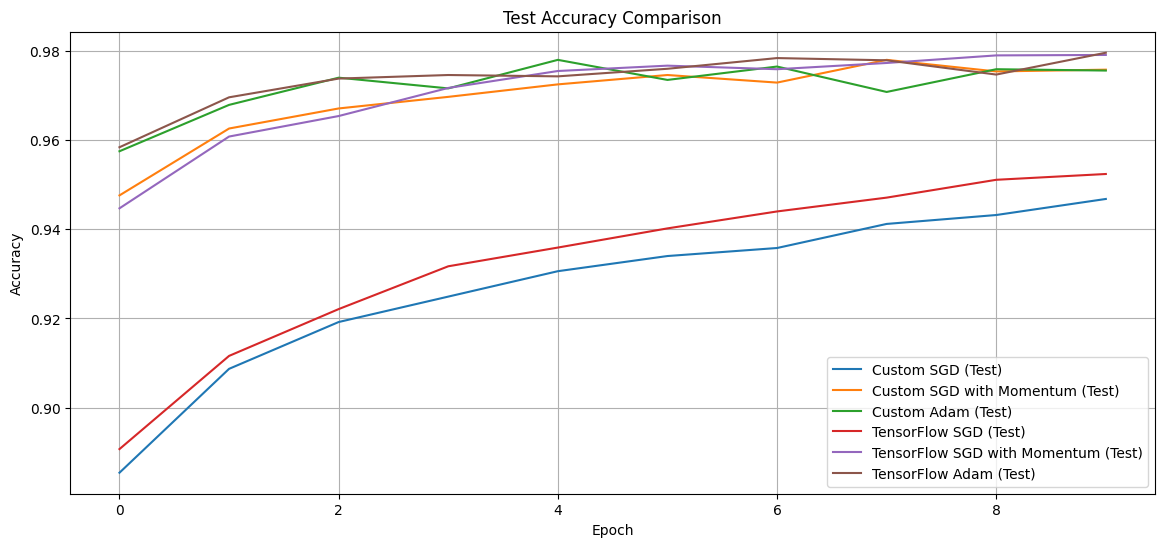

In [11]:
# Plot Training Accuracy
plt.figure(figsize=(14, 6))
for name, (train_accuracies, _) in results.items():
    plt.plot(train_accuracies, label=f"{name} (Train)")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(14, 6))
for name, (_, test_accuracies) in results.items():
    plt.plot(test_accuracies, label=f"{name} (Test)")
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
print("\nComparison of Final Test Accuracies:")
for name, (_, test_accuracies) in results.items():
    print(f"{name}: {test_accuracies[-1]:.4f}")



Comparison of Final Test Accuracies:
Custom SGD: 0.9468
Custom SGD with Momentum: 0.9758
Custom Adam: 0.9756
TensorFlow SGD: 0.9524
TensorFlow SGD with Momentum: 0.9791
TensorFlow Adam: 0.9796
